## Feature extraction - Orologio di Marco (dati raccolti il 10 maggio 2024)

#### Si assume di partire da un file .json "circle_data_marco" o "double_hand_clap", stare attenti ai percorsi dei file o rendere parametrico se c'è tempo

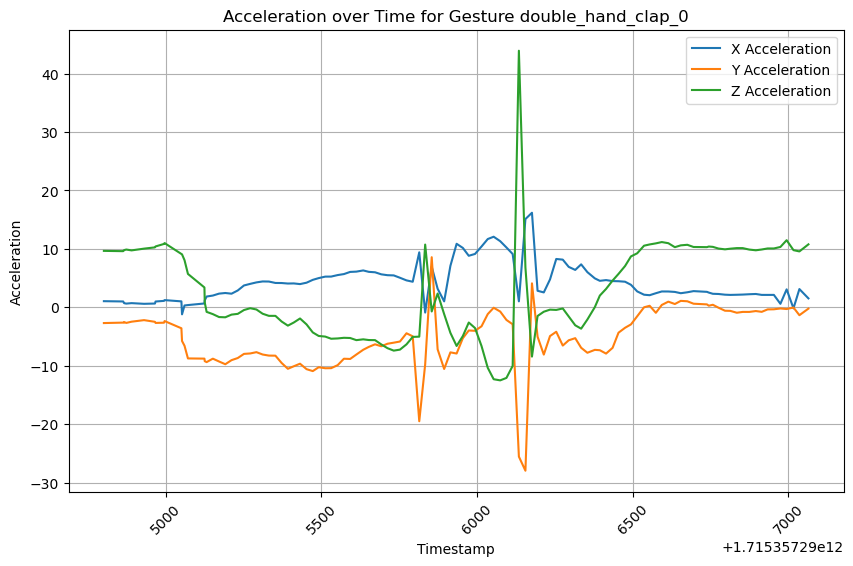

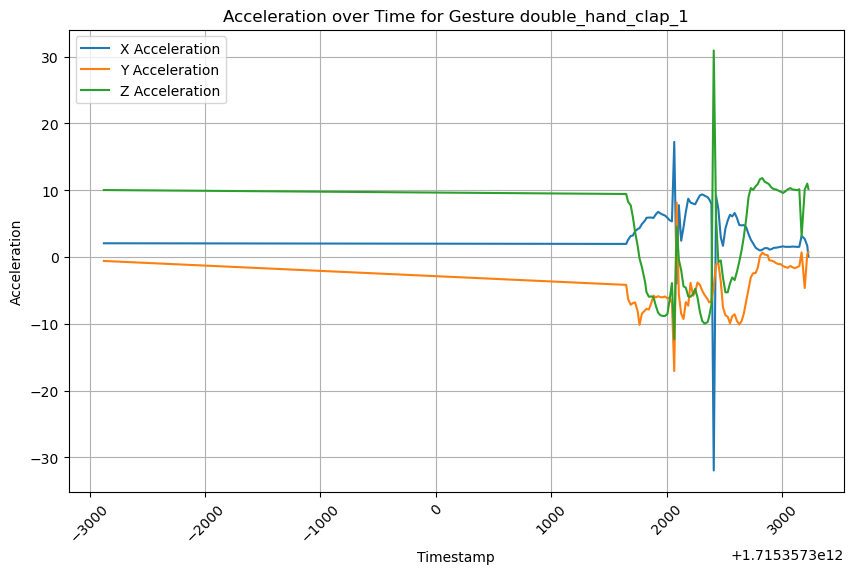

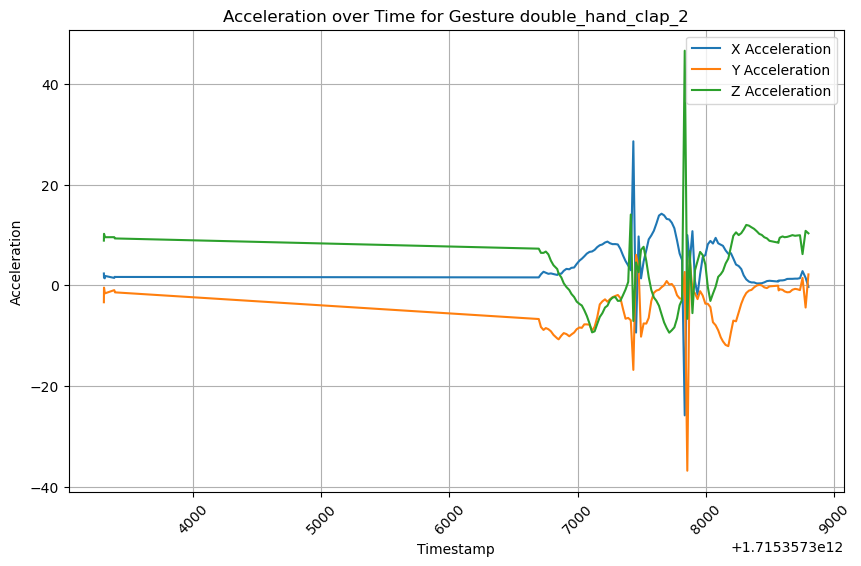

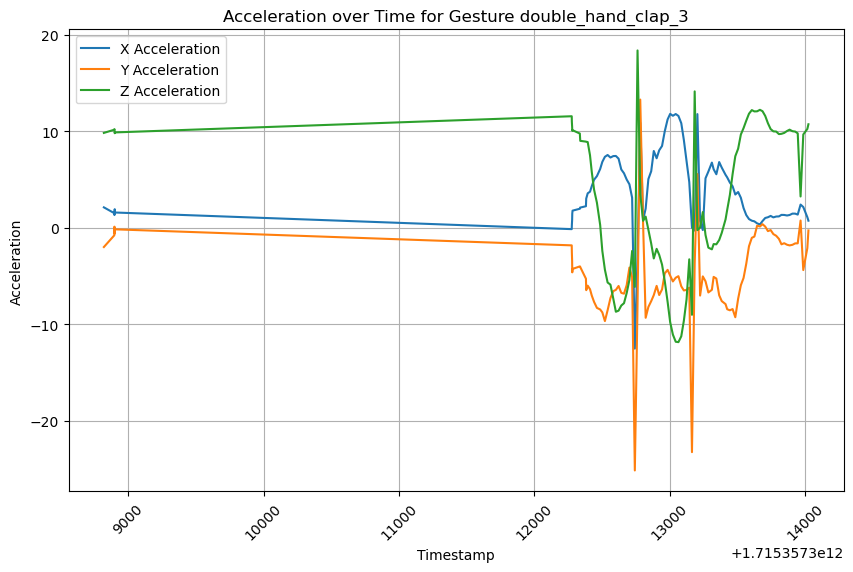

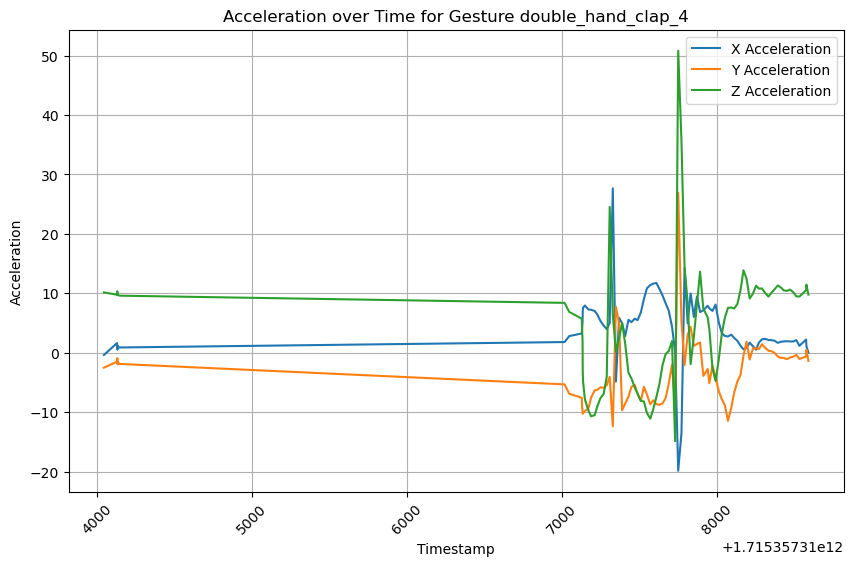

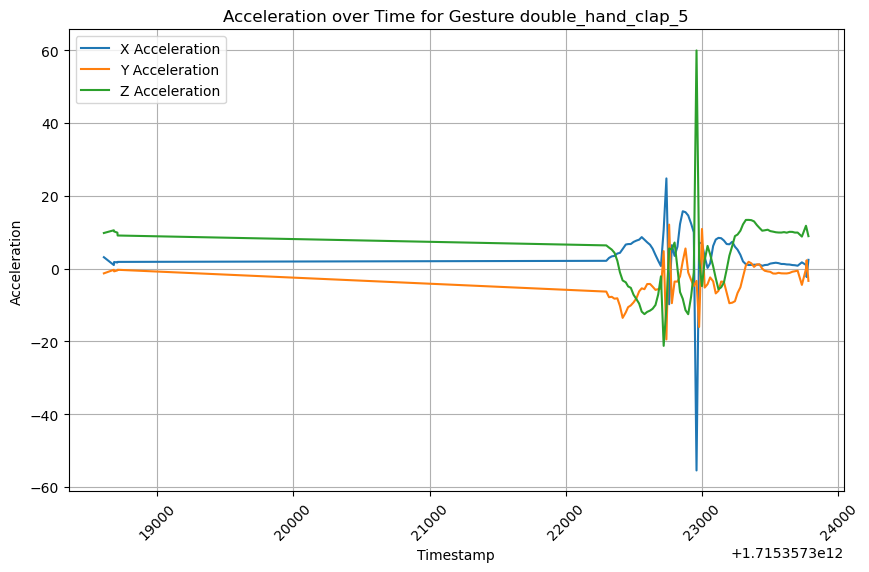

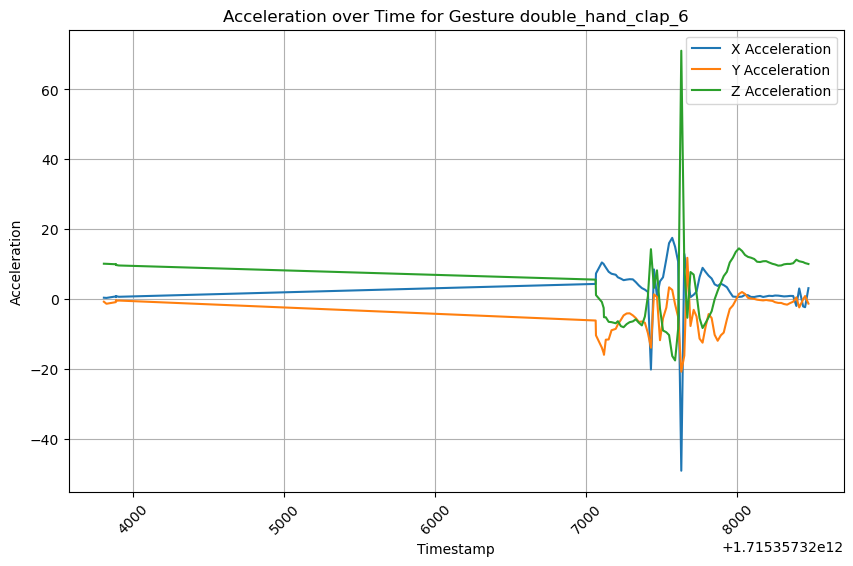

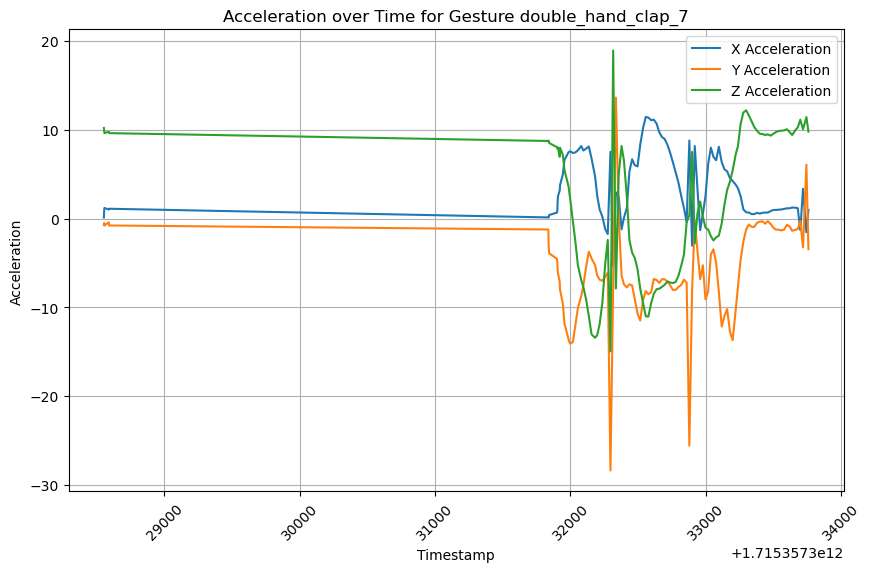

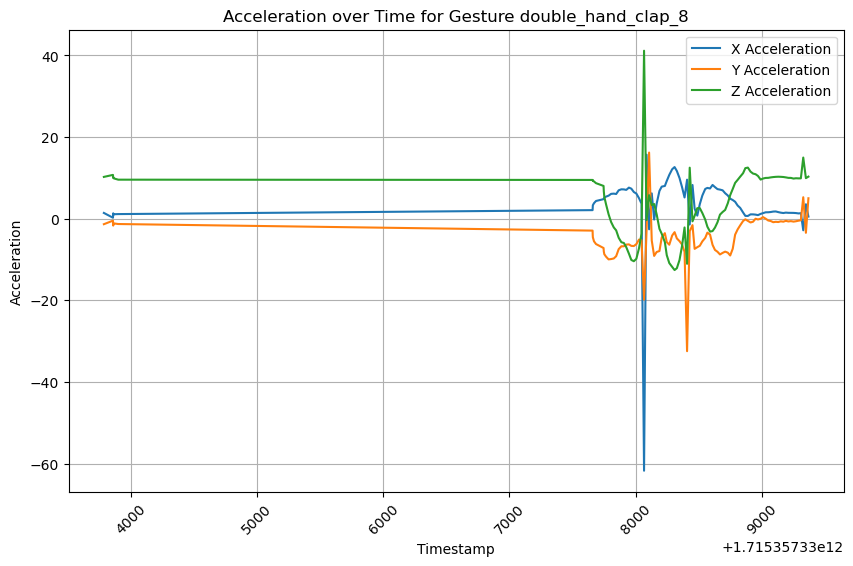

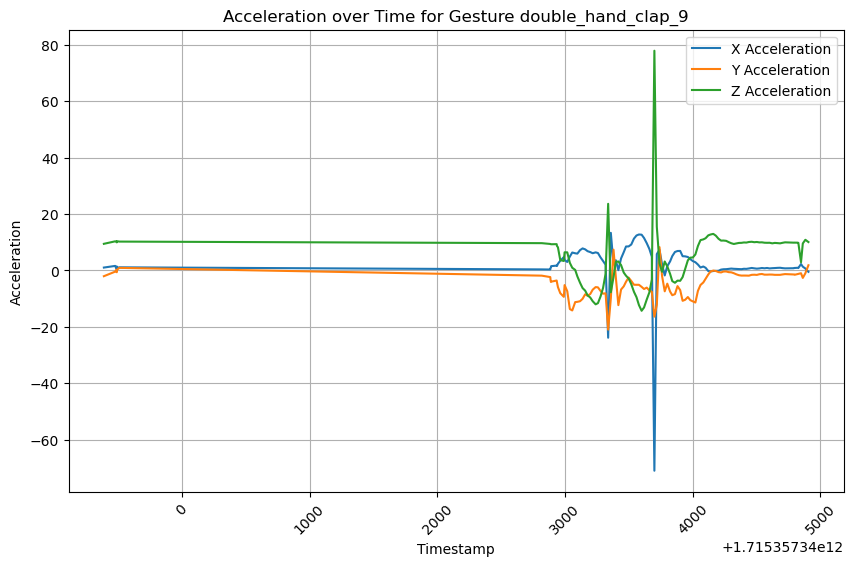

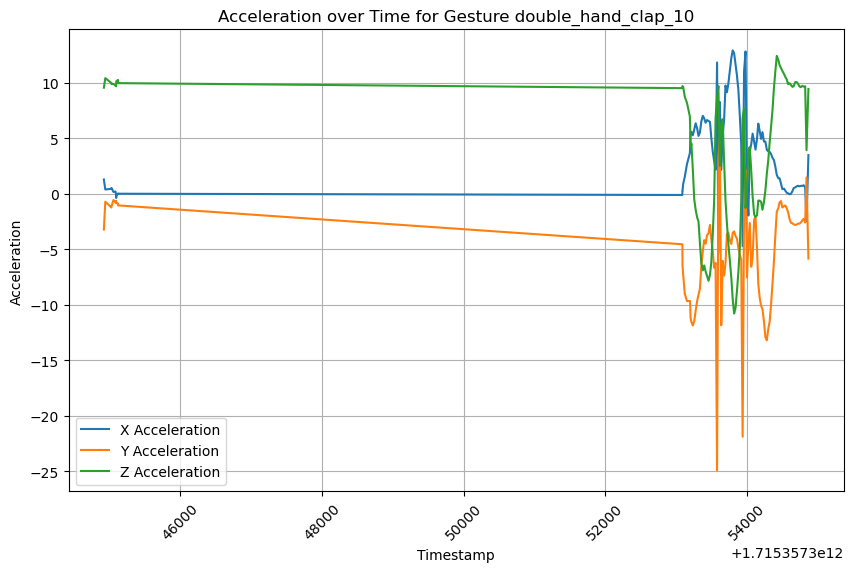

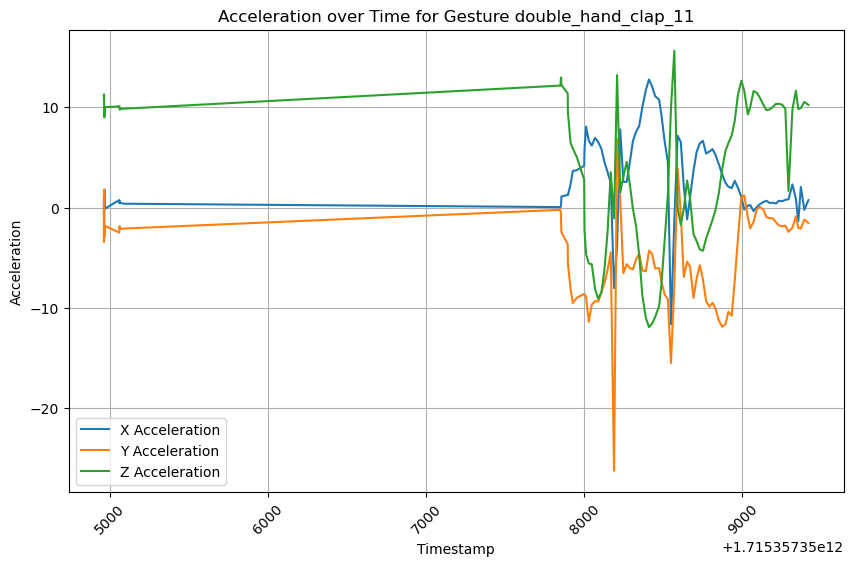

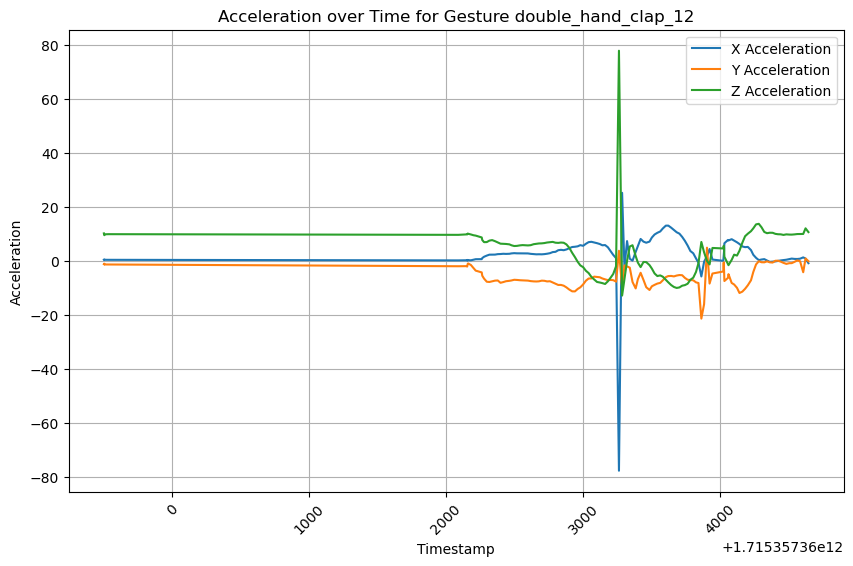

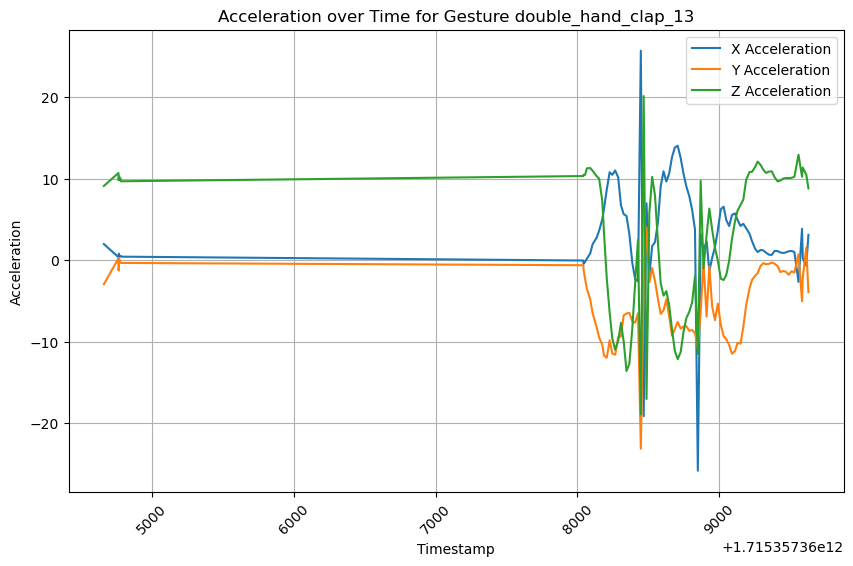

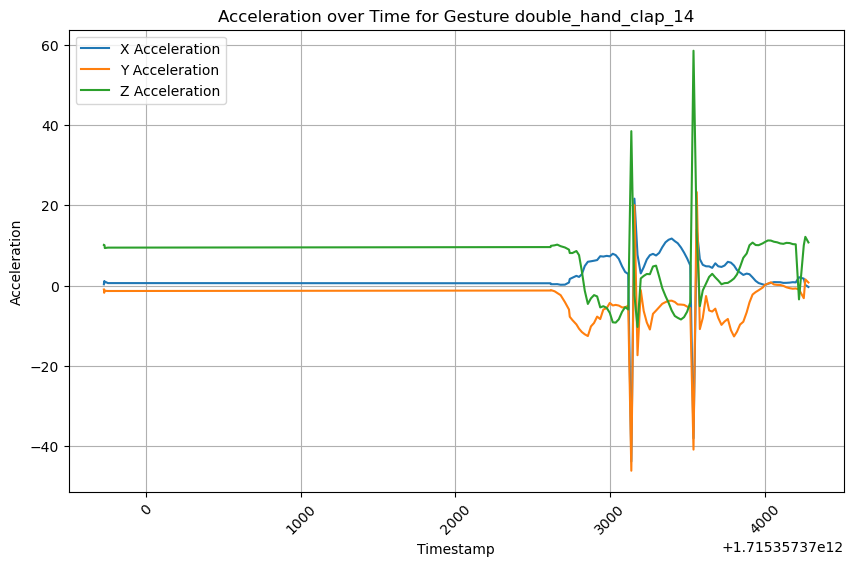

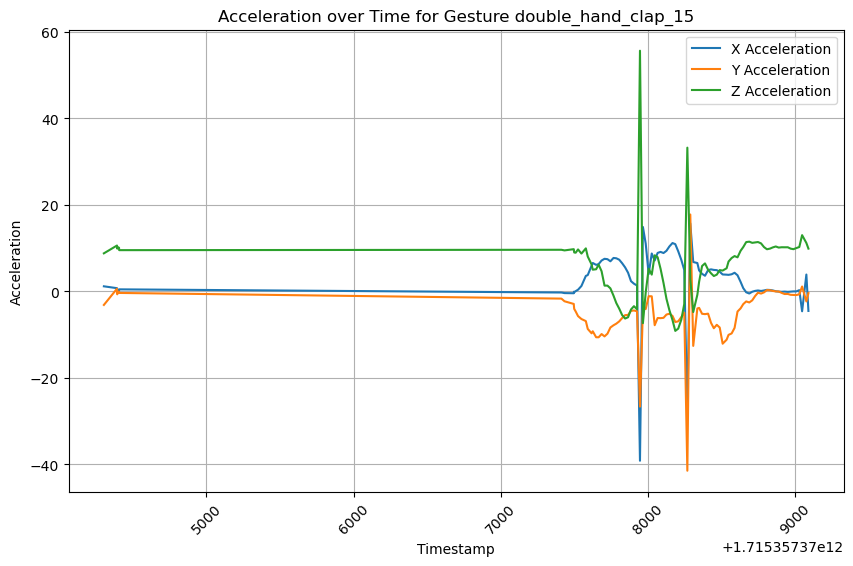

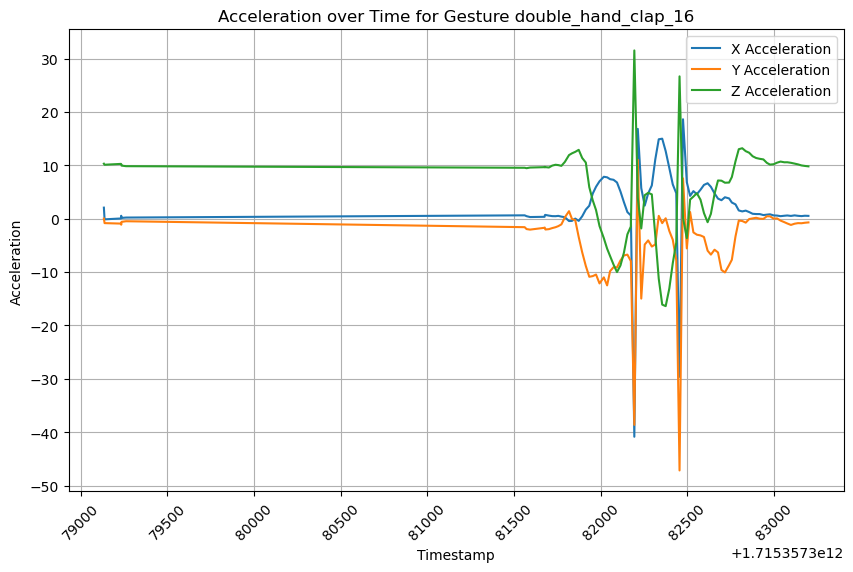

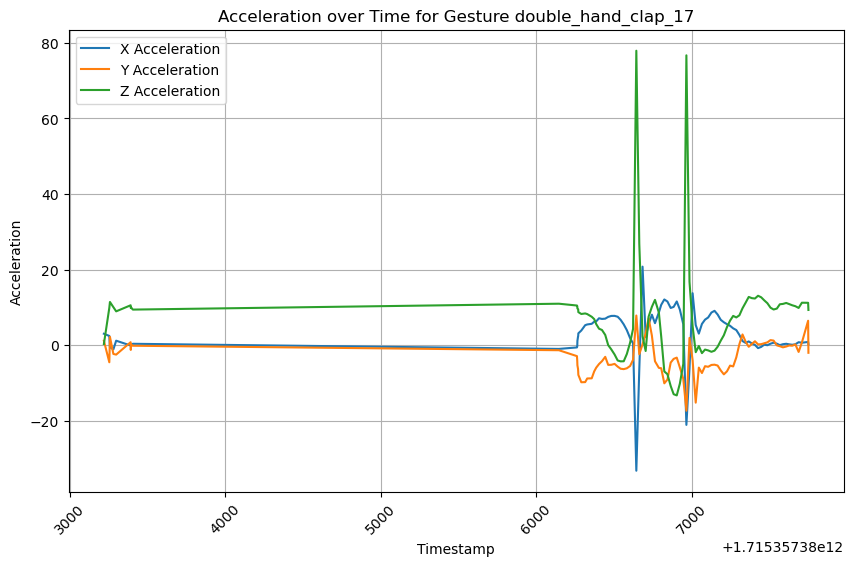

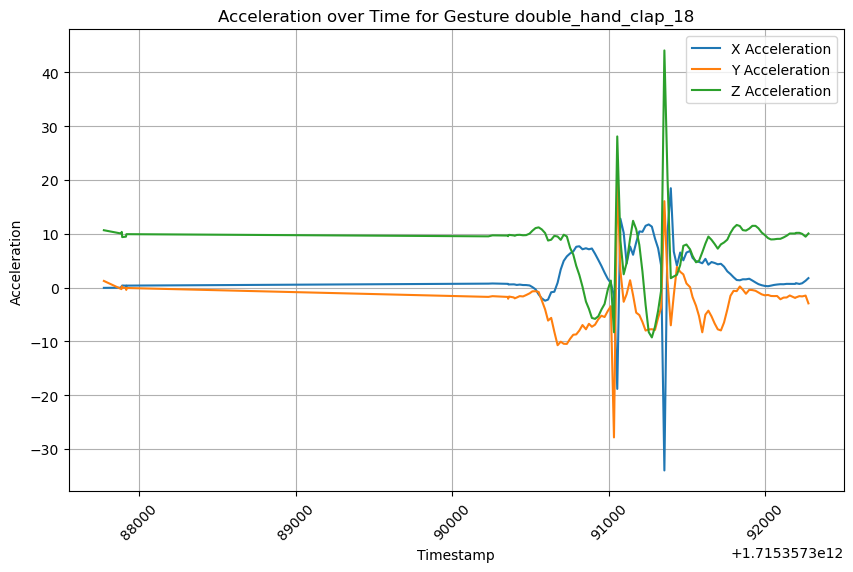

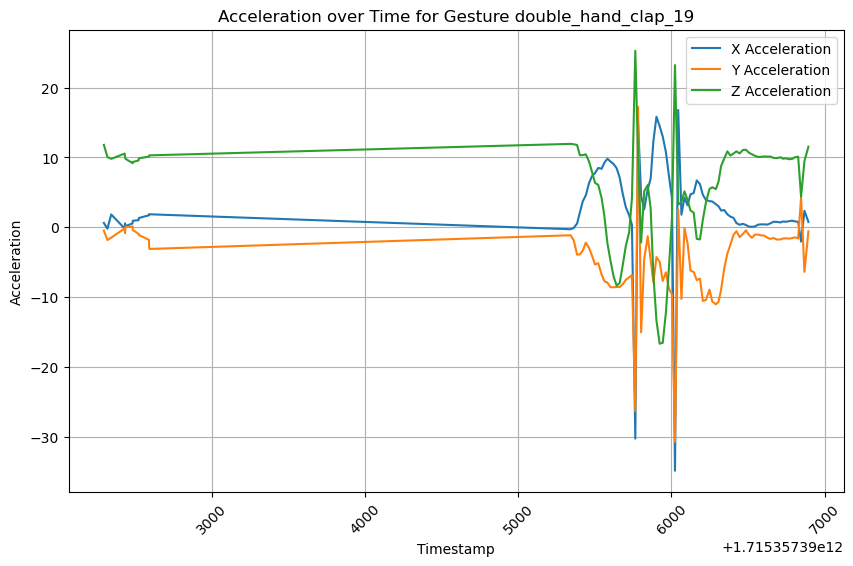

In [52]:
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Carica i dati dal file JSON
with open('double_hand_clap.json', 'r') as file:
    data = json.load(file)

# Creare un dizionario per raggruppare i dati per GestureID
gesture_data = {}
for entry in data:
    gesture_id = entry['GestureID']
    if gesture_id not in gesture_data:
        gesture_data[gesture_id] = {'timestamps': [], 'xTimeSeries': [], 'yTimeSeries': [], 'zTimeSeries': []}
    gesture_data[gesture_id]['timestamps'].extend(entry['timestamps'])
    gesture_data[gesture_id]['xTimeSeries'].extend(entry['xTimeSeries'])
    gesture_data[gesture_id]['yTimeSeries'].extend(entry['yTimeSeries'])
    gesture_data[gesture_id]['zTimeSeries'].extend(entry['zTimeSeries'])

# Tracciare un grafico per ogni gesto
for gesture_id, gesture_values in gesture_data.items():
    timestamps = gesture_values['timestamps']
    x_series = gesture_values['xTimeSeries']
    y_series = gesture_values['yTimeSeries']
    z_series = gesture_values['zTimeSeries']


    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, x_series, label='X Acceleration')
    plt.plot(timestamps, y_series, label='Y Acceleration')
    plt.plot(timestamps, z_series, label='Z Acceleration')
    plt.xlabel('Timestamp')
    plt.ylabel('Acceleration')
    plt.title(f'Acceleration over Time for Gesture {gesture_id}')
    plt.legend()
    plt.xticks(rotation=45)  # Ruota le etichette sull'asse x per una migliore leggibilità
    plt.grid(True)
    plt.show()


## Passo 2: Estrazione delle possibili features a comune con la gesture "cerchio"

### Energia del segnale (approssimazione del Teorema di Parseval di Comunicazioni Numeriche)

In [53]:
import json
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

# Funzione per calcolare l'energia del segnale
def calculate_signal_energy(x, y, z):
    signal_energy = 0
    for i in range(len(x)):
        energy = x[i]**2 + y[i]**2 + z[i]**2
        signal_energy += energy
    return signal_energy

# Calcolo della trasformata e dei picchi
def fourier_transform_amplitude(data):
    # Calcola la trasformata di Fourier
    fft_result = np.fft.fft(data)

    # Calcola le frequenze associate ai coefficienti della trasformata di Fourier
    frequencies = np.fft.fftfreq(len(data))

    # Identifica l'indice del coefficiente di frequenza corrispondente alla frequenza principale (massima ampiezza)
    main_frequency_index = np.argmax(np.abs(frequencies))

    # Calcola l'ampiezza come il modulo del coefficiente della trasformata di Fourier alla frequenza principale
    amplitude = np.abs(fft_result[main_frequency_index])

    return str(amplitude)


# salvo energia
energy = {}

for gesture_id, gesture_values in gesture_data.items():
    timestamps = gesture_values['timestamps']
    x_series = gesture_values['xTimeSeries']
    y_series = gesture_values['yTimeSeries']
    z_series = gesture_values['zTimeSeries']
    
    # Calcola l'energia del segnale
    signal_energy = calculate_signal_energy(x_series, y_series, z_series)
    energy[gesture_id] = str(signal_energy)
    print('Signal energy for gesture: ' + gesture_id + ': -> ' + str(signal_energy))

    print ('ASSE Z:' + fourier_transform_amplitude(z_series))

Signal energy for gesture: double_hand_clap_0: -> 17269.78491885176
ASSE Z:15.658079311999984
Signal energy for gesture: double_hand_clap_1: -> 12140.213980168228
ASSE Z:43.38533679015557
Signal energy for gesture: double_hand_clap_2: -> 18909.654115574078
ASSE Z:47.583985673381896
Signal energy for gesture: double_hand_clap_3: -> 13861.389764554624
ASSE Z:8.851361249999995
Signal energy for gesture: double_hand_clap_4: -> 17927.21482179378
ASSE Z:46.78509978
Signal energy for gesture: double_hand_clap_5: -> 19545.895206187924
ASSE Z:46.713265479999976
Signal energy for gesture: double_hand_clap_6: -> 20869.95817682407
ASSE Z:67.68229961578405
Signal energy for gesture: double_hand_clap_7: -> 16600.5709404331
ASSE Z:27.978641209999996
Signal energy for gesture: double_hand_clap_8: -> 19248.885282171825
ASSE Z:70.26128903054419
Signal energy for gesture: double_hand_clap_9: -> 27410.940684743477
ASSE Z:99.05051828
Signal energy for gesture: double_hand_clap_10: -> 13879.779009326927
ASS

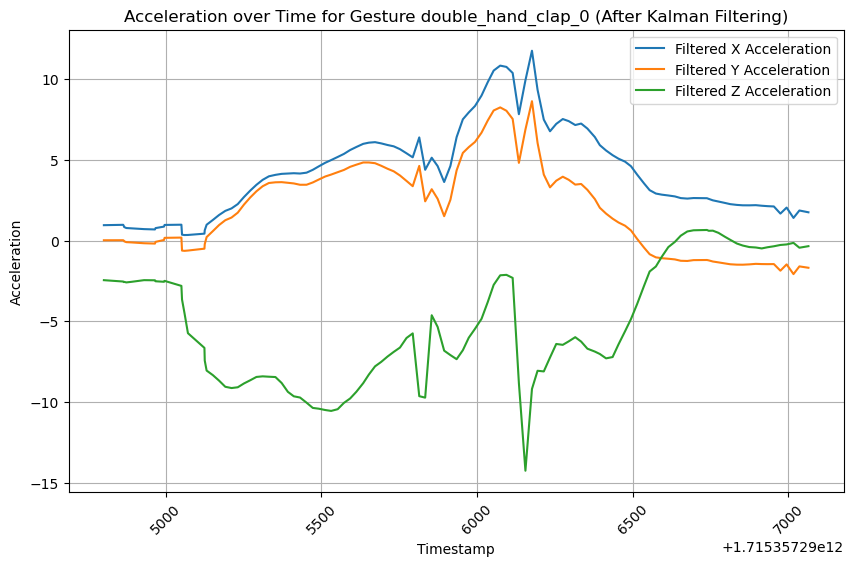

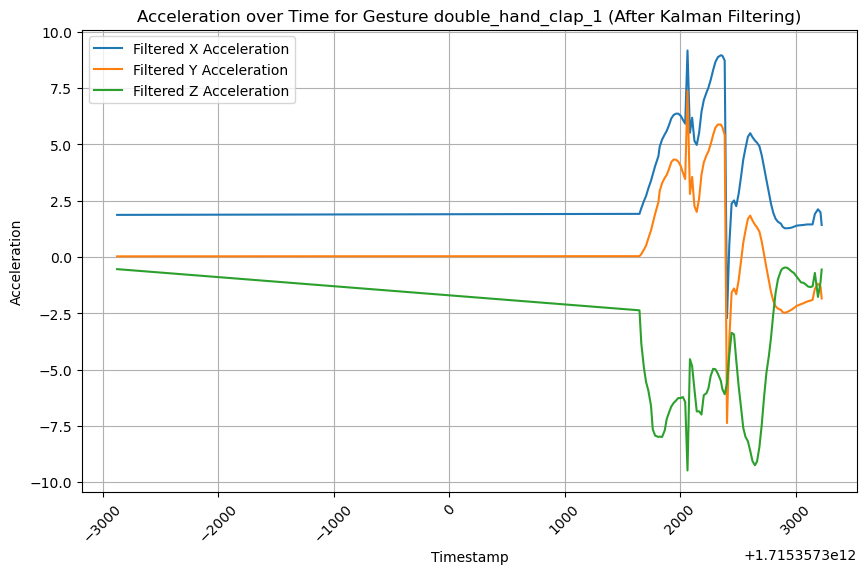

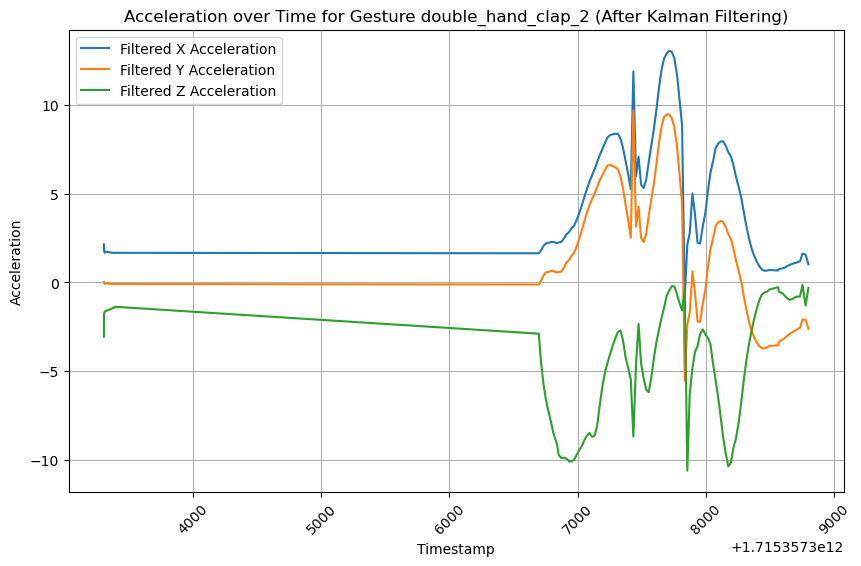

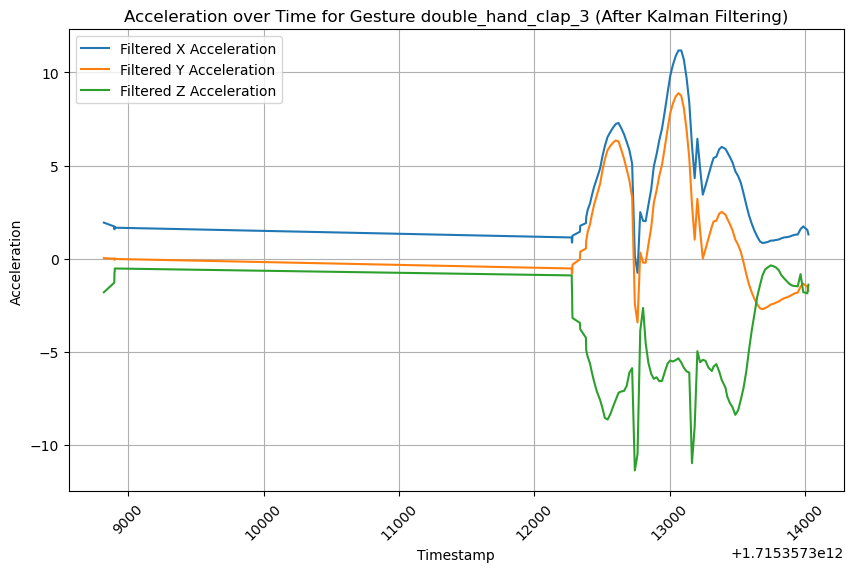

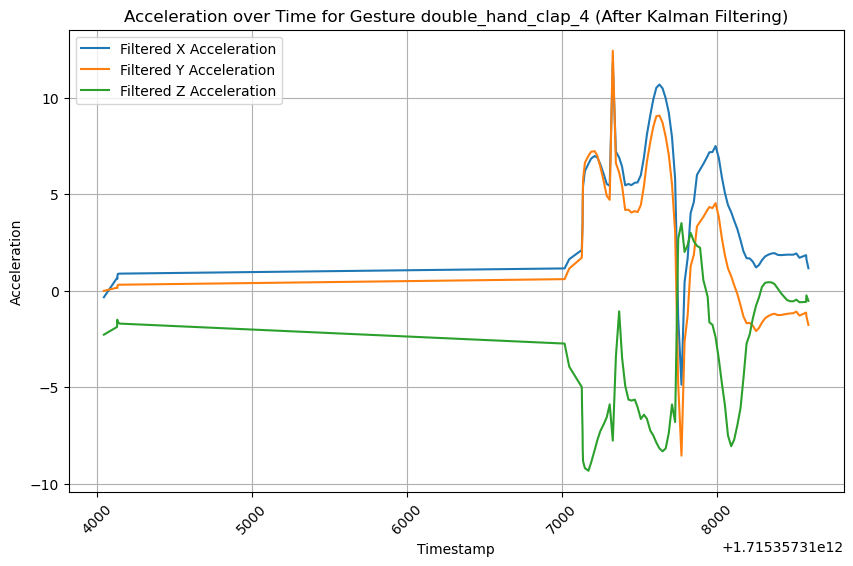

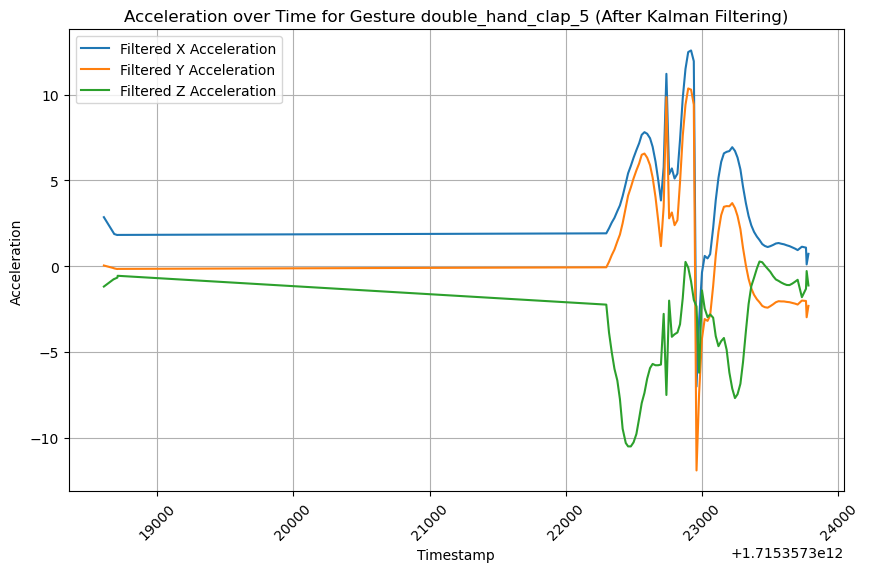

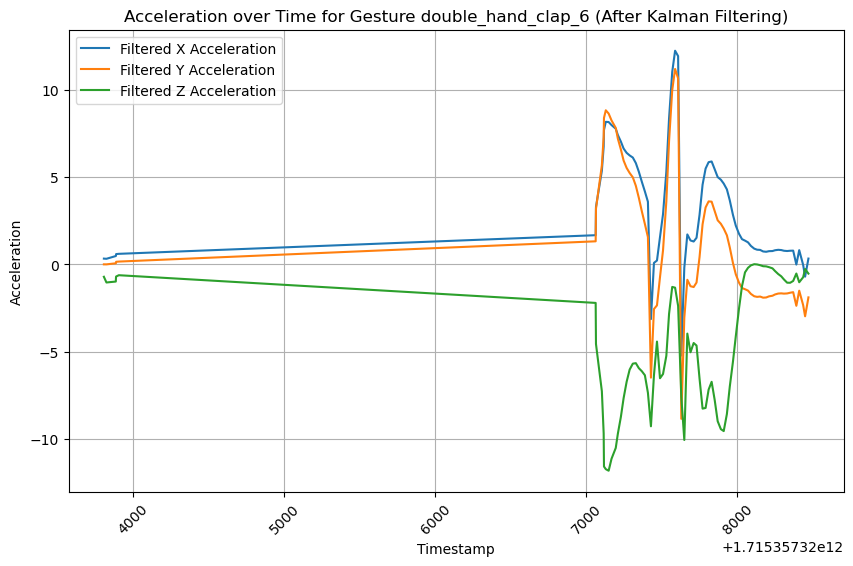

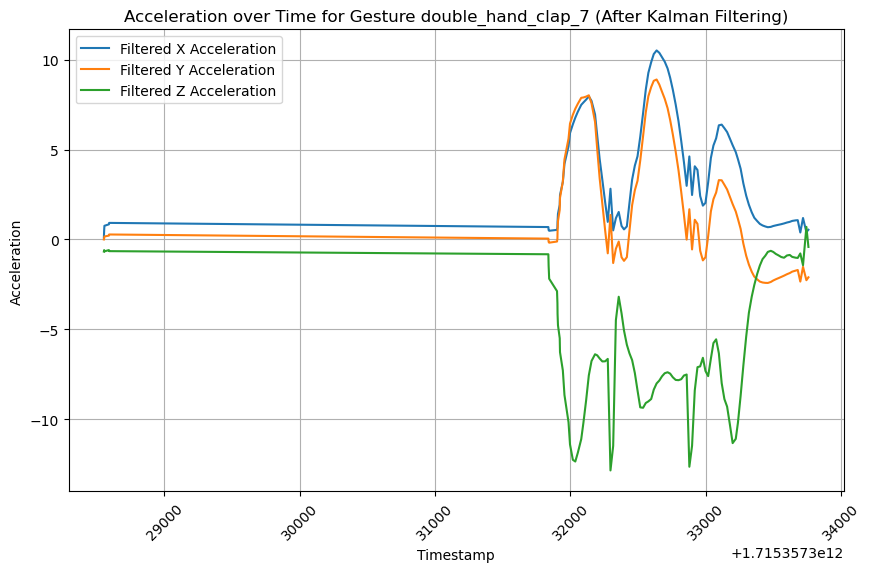

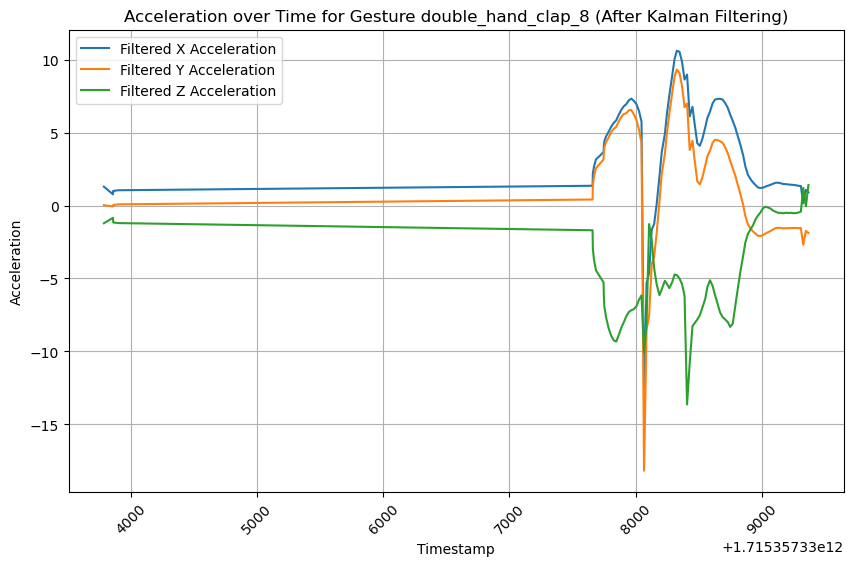

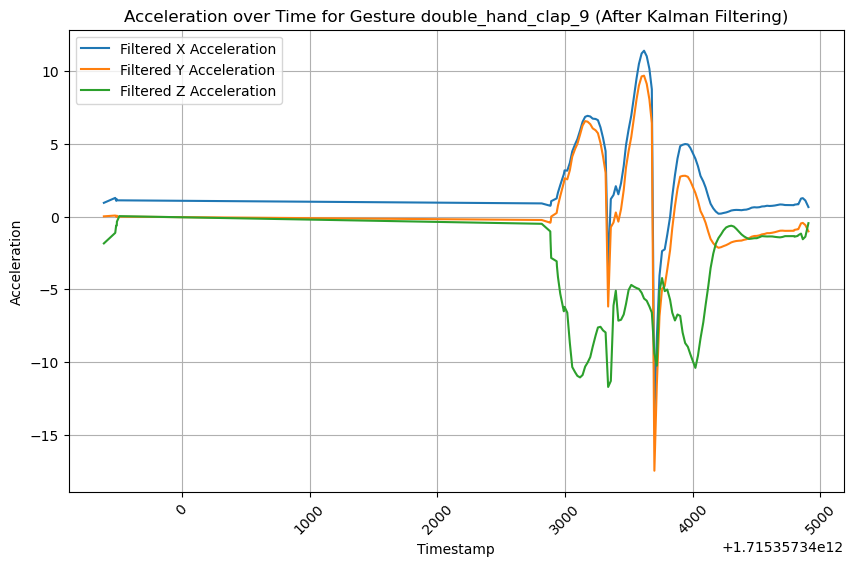

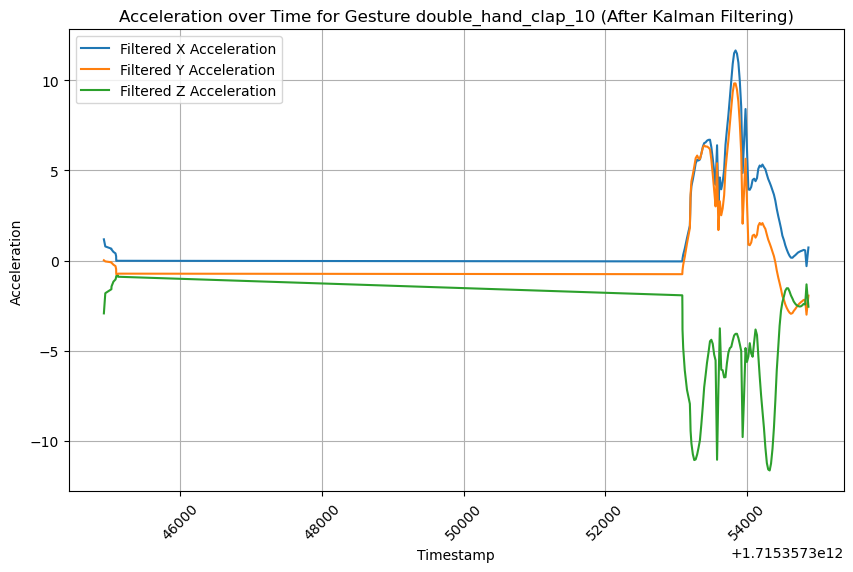

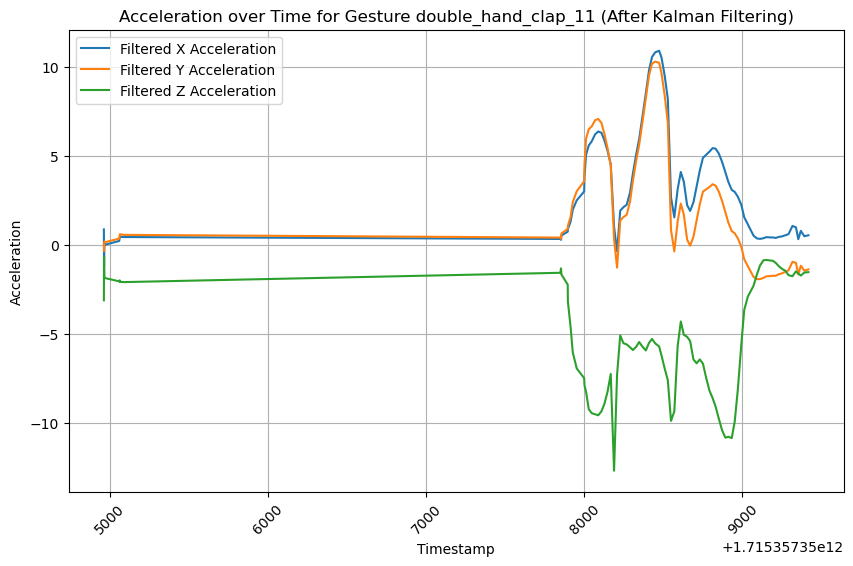

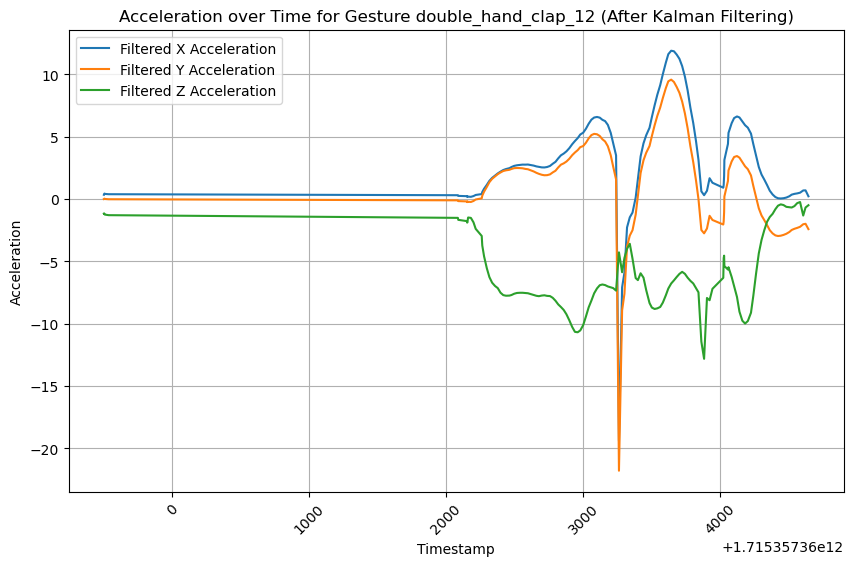

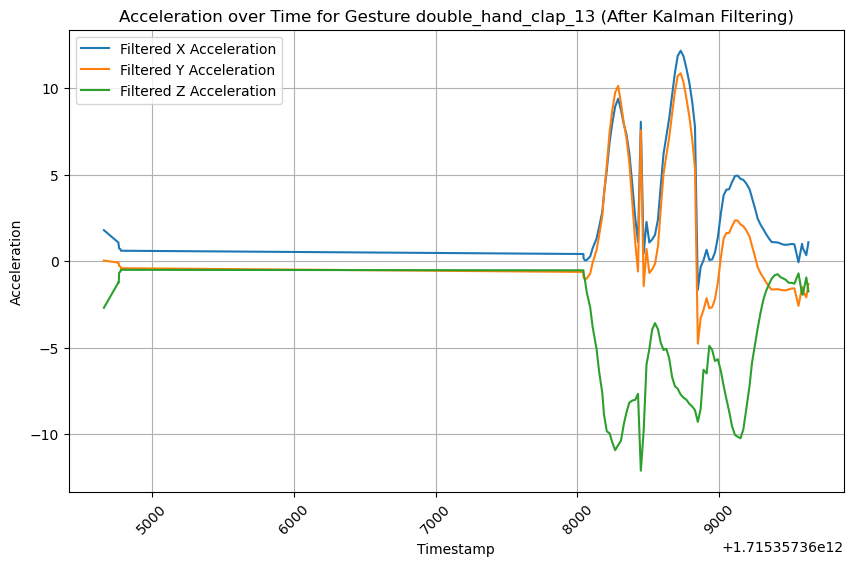

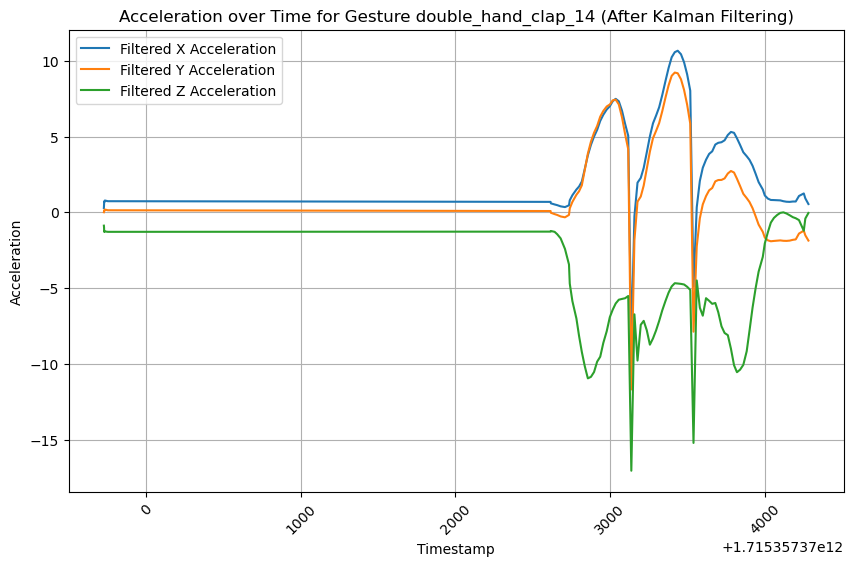

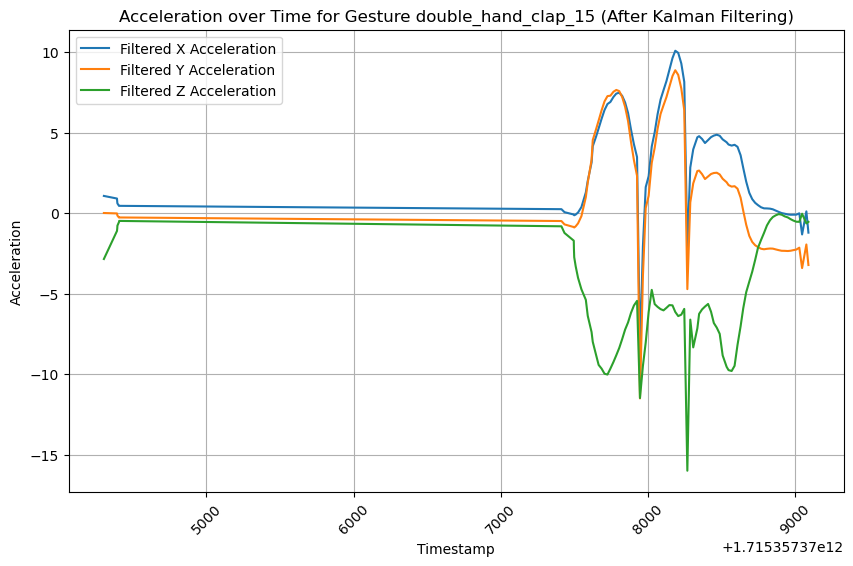

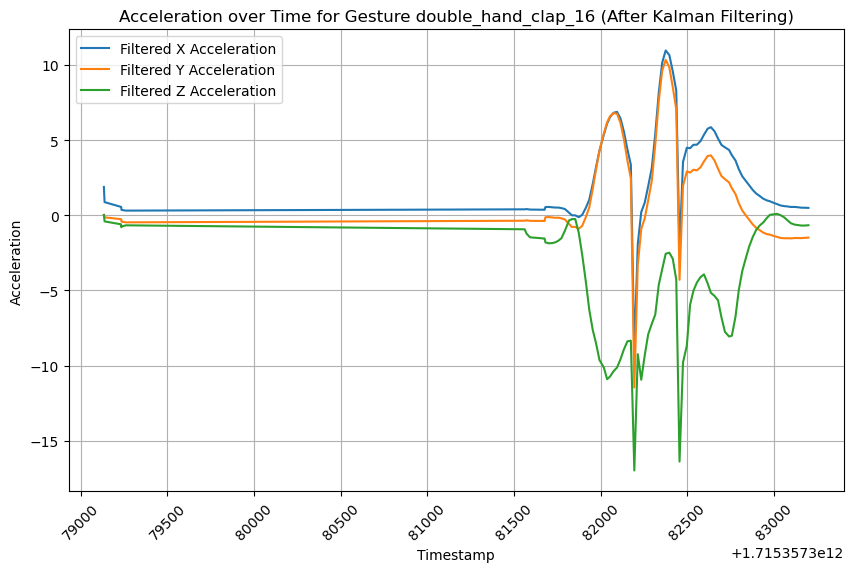

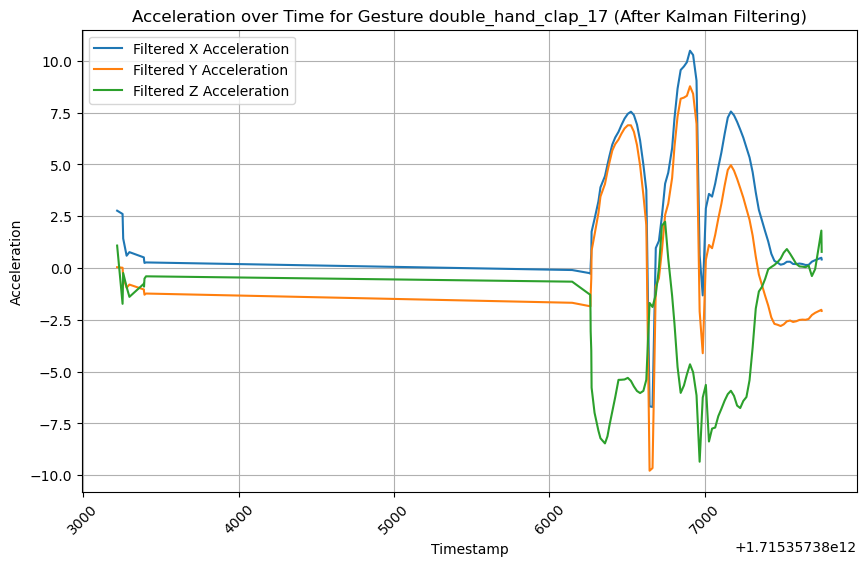

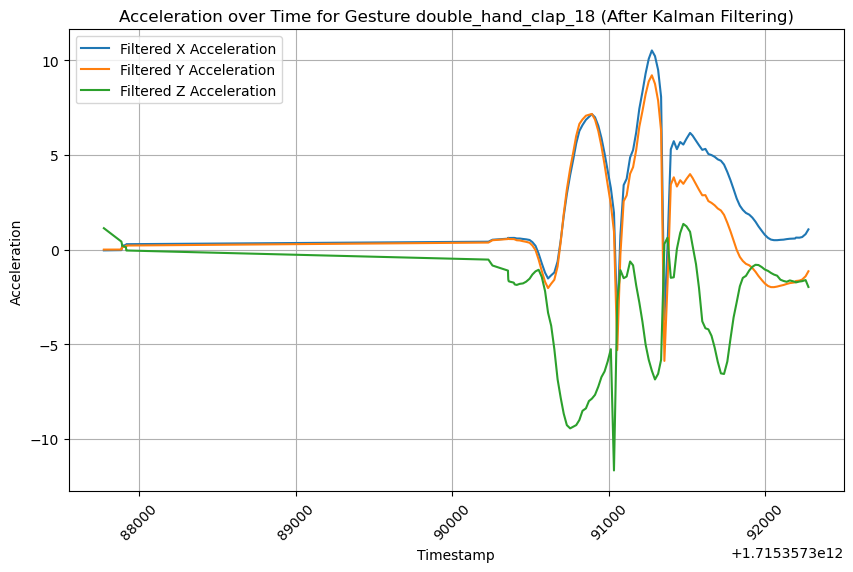

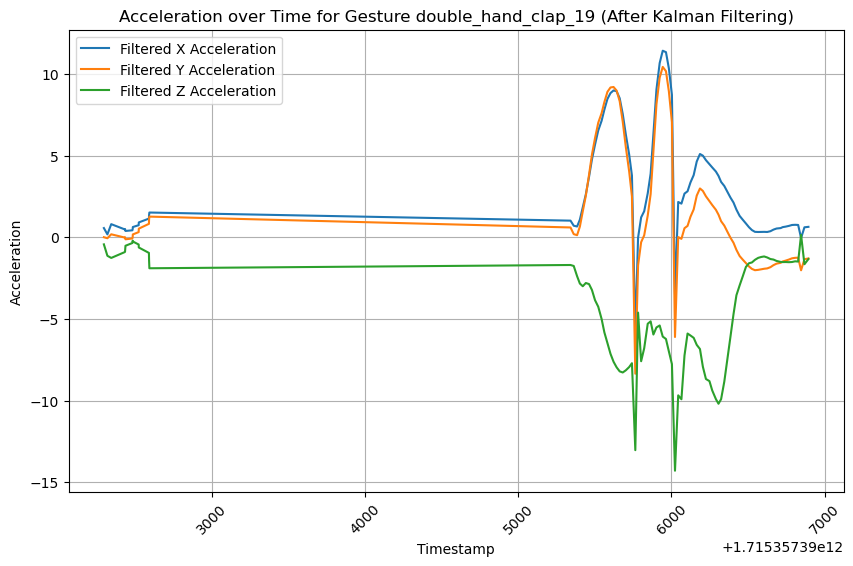

In [54]:
import json
import matplotlib.pyplot as plt
from datetime import datetime
from filterpy.kalman import KalmanFilter
from scipy.signal import find_peaks
import numpy as np

# Carica i dati dal file JSON
with open('double_hand_clap.json', 'r') as file:
    data = json.load(file)

# Creare un dizionario per raggruppare i dati per GestureID
gesture_data = {}
for entry in data:
    gesture_id = entry['GestureID']
    if gesture_id not in gesture_data:
        gesture_data[gesture_id] = {'timestamps': [], 'xTimeSeries': [], 'yTimeSeries': [], 'zTimeSeries': []}
    gesture_data[gesture_id]['timestamps'].extend(entry['timestamps'])
    gesture_data[gesture_id]['xTimeSeries'].extend(entry['xTimeSeries'])
    gesture_data[gesture_id]['yTimeSeries'].extend(entry['yTimeSeries'])
    gesture_data[gesture_id]['zTimeSeries'].extend(entry['zTimeSeries'])

# Funzione per applicare il filtro di Kalman ai dati accelerometrici
def apply_kalman_filter(data):
    dt = 0.015  # Intervallo di campionamento dei dati
    kf = KalmanFilter(dim_x=6, dim_z=3)  # 6 variabili di stato (posizione, velocità, accelerazione per X, Y, Z), 3 misure (accelerazione per X, Y, Z)

    # Definizione delle matrici di transizione di stato e di osservazione
    kf.F = np.array([[1, dt, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 0],
                     [0, 0, 1, dt, 0, 0],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 1, dt],
                     [0, 0, 0, 0, 0, 1]])

    kf.H = np.array([[1, 0, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0]])

    # Definizione delle matrici di covarianza del processo e di osservazione
    kf.Q *= 0.01
    kf.R *= 0.1

    filtered_data = []

    for i in range(len(data['timestamps'])):
        measurement = np.array([[data['xTimeSeries'][i]], [data['yTimeSeries'][i]], [data['zTimeSeries'][i]]])
        kf.predict()
        kf.update(measurement)
        filtered_data.append(kf.x[:3].flatten())

    return filtered_data


filtered_gesture_dict = {}
# Tracciare un grafico per ogni gesto
for gesture_id, gesture_values in gesture_data.items():
    timestamps = gesture_values['timestamps']
    x_series = gesture_values['xTimeSeries']
    y_series = gesture_values['yTimeSeries']
    z_series = gesture_values['zTimeSeries']

    # Applicare il filtro di Kalman ai dati accelerometrici
    filtered_data = apply_kalman_filter(gesture_values)

    filtered_x_series = [data[0] for data in filtered_data]
    filtered_y_series = [data[1] for data in filtered_data]
    filtered_z_series = [data[2] for data in filtered_data]

    filtered_gesture_dict[gesture_id] = filtered_data
    
    # Grafico dopo l'applicazione del filtro di Kalman
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, filtered_x_series, label='Filtered X Acceleration')
    plt.plot(timestamps, filtered_y_series, label='Filtered Y Acceleration')
    plt.plot(timestamps, filtered_z_series, label='Filtered Z Acceleration')
    plt.xlabel('Timestamp')
    plt.ylabel('Acceleration')
    plt.title(f'Acceleration over Time for Gesture {gesture_id} (After Kalman Filtering)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [55]:
def calculate_gradient_direction(filtered_x_series, filtered_y_series, filtered_z_series):
    # Calcola il gradiente utilizzando il metodo dei differenziali centrali
    gradient_x = np.gradient(filtered_x_series)
    gradient_y = np.gradient(filtered_y_series)
    gradient_z = np.gradient(filtered_z_series)

    # Calcola il modulo del gradiente steepest descent
    gradient_magnitude = np.sqrt(np.square(gradient_x) + np.square(gradient_y) + np.square(gradient_z))

    # Trova l'indice del massimo modulo del gradiente
    max_gradient_index = np.argmax(gradient_magnitude)

    # Calcola la direzione del gradiente massimo
    max_gradient_direction = np.arctan2(gradient_y[max_gradient_index], gradient_x[max_gradient_index])

    return max_gradient_direction, gradient_magnitude[max_gradient_index]

## Modifica il nome del file csv! e anche della classe!

In [56]:
import csv

# Nome del file csv
csv_file = 'clap_feature_dataset.csv'

# Apro il CSV in modalità scrittura
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Scrivo l'intestazione del file csv
    writer.writerow(["class", "SignalEnergy", "XAmplitude", "YAmplitude", "ZAmplitude", "GradientDirection", "GradientNormSteep"])

    for gesture_id, filtered_data in filtered_gesture_dict.items():
        filtered_x_series = [data[0] for data in filtered_data]
        filtered_y_series = [data[1] for data in filtered_data]
        filtered_z_series = [data[2] for data in filtered_data]
        
        # Calcola l'energia del segnale
        signal_energy = calculate_signal_energy(filtered_x_series, filtered_y_series, filtered_z_series)
        
        # Stampa la amplitude per i tre assi
        x_amplitude = fourier_transform_amplitude(filtered_x_series)
        y_amplitude = fourier_transform_amplitude(filtered_y_series)
        z_amplitude = fourier_transform_amplitude(filtered_z_series)

        # Supponiamo che filtered_x_series, filtered_y_series e filtered_z_series siano le serie filtrate per un gesto specifico
        # È possibile utilizzare la funzione calculate_gradient_direction per ottenere la direzione del gradiente massimo e il modulo del gradiente steepest descent
        max_gradient_direction, gradient_magnitude = calculate_gradient_direction(filtered_x_series, filtered_y_series, filtered_z_series)

        writer.writerow(["clap", signal_energy, x_amplitude, y_amplitude, z_amplitude, max_gradient_direction, gradient_magnitude])
print("Dati salvati con successo in", csv_file)

Dati salvati con successo in clap_feature_dataset.csv
